# Homework 6

## Math Tools for Neural and Cognitive Science

Reuben Feinman

11/26/2017

NOTE: grader must have Python bindings for MATLAB installed. See here for details: https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html

In [1]:
from __future__ import division, print_function

import os
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(os.path.realpath('.'),nargout=0)

# Problem #1

In [3]:
def runGaussNoiseExpt(kernel, duration):
    """
    A wrapper function for the matlab function runGaussNoiseExpt.
    Does the necessary data type transformations to the inputs, 
    calls the matlab function, transforms the output back 
    into numpy, and returns.
    """
    kernel_mat = matlab.double(kernel.tolist())
    spikes, stimuli = eng.runGaussNoiseExpt(kernel_mat, duration, nargout=2)
    
    return np.asarray(spikes, dtype=np.bool).reshape(-1,), np.asarray(stimuli, dtype=np.float32)

## (a)

In [4]:
# define the desired kernel
kernel = np.asarray([
    [-1,-2,0],
    [-2,0,2],
    [1,2,0]
])/6.
# divide by norm
kernel /= np.linalg.norm(kernel)
# stretch it out
kernel_1d = kernel.reshape(-1,1)

In [34]:
# call the function
spikes, stimuli = runGaussNoiseExpt(kernel_1d, 100)
# compute the linear filter response to the stimuli
stimuli_responses = np.matmul(stimuli, kernel_1d)

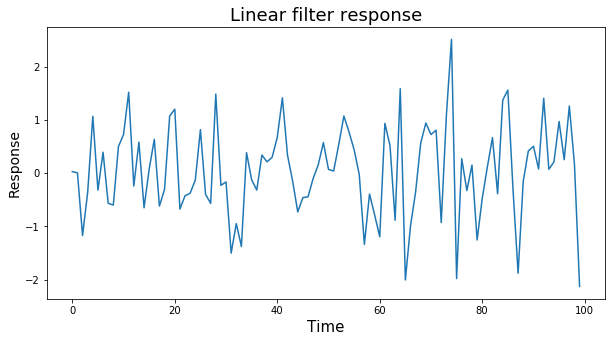

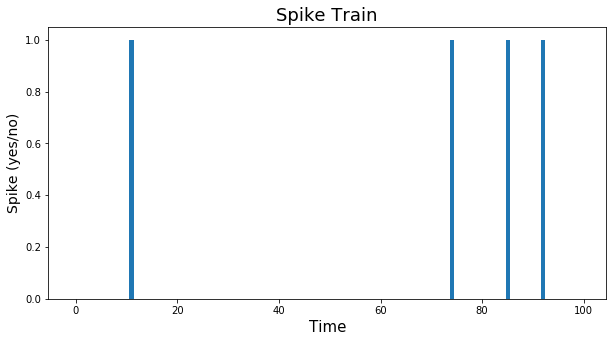

In [36]:
# Plot filter response
plt.figure(figsize=(10,5))
plt.plot(range(100),stimuli_responses)
plt.title('Linear filter response', fontsize=18)
plt.ylabel('Response', fontsize=14)
plt.xlabel('Time', fontsize=15)
plt.show()
# Plot spike train
plt.figure(figsize=(10,5))
plt.bar(range(100),spikes)
plt.title('Spike Train', fontsize=18)
plt.ylabel('Spike (yes/no)', fontsize=14)
plt.xlabel('Time', fontsize=15)
plt.show()

In [37]:
# I'm not sure what exactly they want with the 2D scatter plot but
# my best guess is something like matlab's "imagesc" function. Writing
# that function here...
def imagesc(C, title, size):
    """
    A function to replicate matlab's 'imagesc' function.
    """
    # Plot it out
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(C, cmap='RdBu_r')

    # Format
    fig = plt.gcf()
    fig.set_size_inches(size[0], size[1])

    # turn off the frame
    ax.set_frame_on(False)
    
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(C.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(C.shape[0]) + 0.5, minor=False)
    ax.set_xticklabels(np.arange(C.shape[0]))
    ax.set_yticklabels(np.arange(C.shape[0]))

    # turn off grid mode
    ax.grid(False)
    
    # set plot title and axis labels
    ax.set_title(title, fontsize=20, y = 1.03)
    
    cbar = plt.colorbar(heatmap)
    cbar.set_label('Intensity', rotation=270, fontsize=20, labelpad=25)

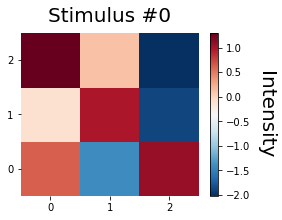

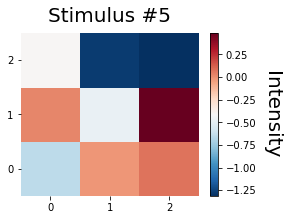

In [38]:
# Plot 2D scatter plot of stimulus 0 and 5
imagesc(
    stimuli[0].reshape(3,3), 
    title='Stimulus #0', 
    size=(4, 3)
)

imagesc(
    stimuli[5].reshape(3,3), 
    title='Stimulus #5', 
    size=(4, 3)
)

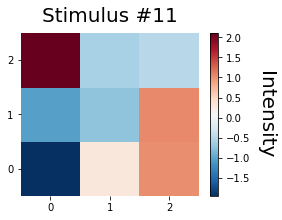

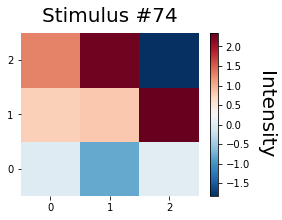

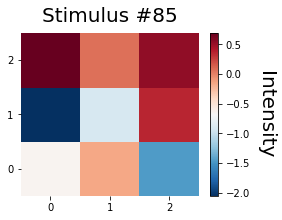

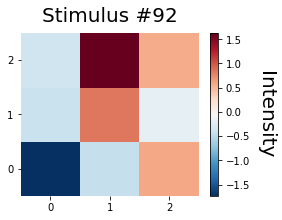

In [40]:
# Now plot 2D scatter plot for each of the stimuli that 
# caused spikes
for i in range(100):
    if spikes[i]:
        imagesc(
            stimuli[i].reshape(3,3), 
            title='Stimulus #%i' % i, 
            size=(4, 3)
        )

It appears that the spikes occur when a stimulus has large values at locations [1,2], [2,2] or [2,1]. This makes sense: those locations correspond to the most positive values in the kernel (2, 2 and 1).

## (b)

In [41]:
# Compute the sta
nb_spikes = 0
sta = np.zeros((9,))
for i in range(100):
    if spikes[i]:
        nb_spikes += 1
        sta += stimuli[i]
sta /= nb_spikes 

# rescale it to have unit norm
sta /= np.linalg.norm(sta)

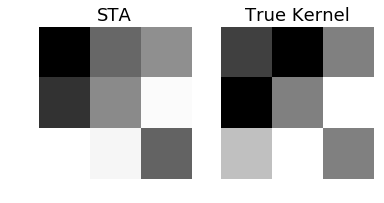

In [42]:
# Display normalized STA as a grayscale image alongside
# the ground truth kernel
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
axes[0].imshow(sta.reshape(3,3), cmap='gray')
axes[0].set_title('STA', fontsize=18)
axes[0].axis('off')
axes[1].imshow(kernel.reshape(3,3), cmap='gray')
axes[1].set_title('True Kernel', fontsize=18)
axes[1].axis('off')
plt.show()

The STA and the true kernel look very simlar - they both have large values at bottom center and right center, and both have very small value at left center.

In [20]:
# For the STA error vs. duration experiment, I will first
# write a function to compute the normalized STA
def compute_sta(spikes, stimuli, normalize=False):
    nb_spikes = 0
    sta = np.zeros((9,))
    for i in range(100):
        if spikes[i]:
            nb_spikes += 1
            sta += stimuli[i]
    sta /= nb_spikes
    if normalize:
        sta /= np.linalg.norm(sta)
    
    return sta

In [43]:
# Now, step through the durations and compute STAs for each,
# computing error each time
durations = np.array([100, 200, 400, 800, 1600, 3200, 6400])
# pre-allocate space for error values
errors = np.zeros_like(durations, dtype=np.float32)
variances = np.zeros_like(durations, dtype=np.float32)
for i, dur in enumerate(durations):
    sta_vals = []
    for j in range(100):
        # run the experiment
        spikes, stimuli = runGaussNoiseExpt(kernel_1d, int(dur))
        if np.where(spikes)[0].shape[0] > 0:
            # if at least one spike occured, this run should
            # contribute to our average. Compute STA...
            sta = compute_sta(spikes, stimuli)
            # sometimes we get NANs. These ruin our computation. 
            # Let's ignore them.
            if not np.isnan(sta).any():
                sta_vals.append(sta)
    sta_vals = np.asarray(sta_vals)
    sta_avg = np.mean(sta_vals, axis=0)
    sta_var = np.var(sta_vals, axis=0)
    # compute the error
    errors[i] = np.linalg.norm(sta_avg - kernel.reshape(9,), ord=1)
    variances[i] = np.mean(sta_var)
    print('duration: %i,\terror: %0.2f,\tvariance: %0.2f' % (dur, errors[i], variances[i]))

duration: 100,	error: 2.43,	variance: 0.31


/Users/reubenfeinman/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


duration: 200,	error: 2.29,	variance: 0.37
duration: 400,	error: 2.42,	variance: 0.33
duration: 800,	error: 2.64,	variance: 0.37
duration: 1600,	error: 2.52,	variance: 0.36
duration: 3200,	error: 2.45,	variance: 0.32
duration: 6400,	error: 2.44,	variance: 0.35


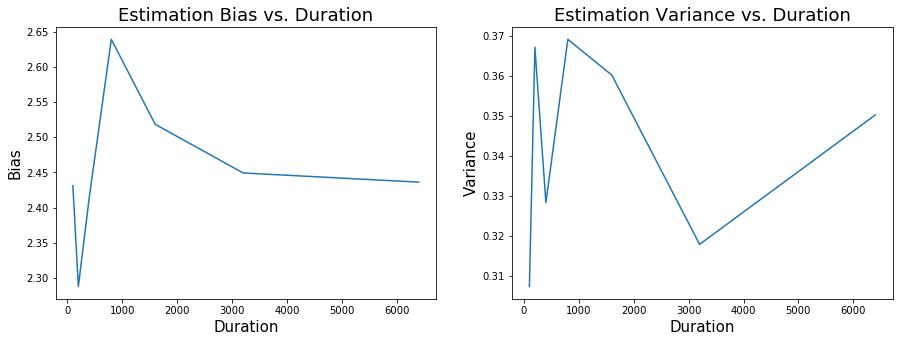

In [52]:
# plot bias and variance as function of duration
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(durations, errors)
axes[0].set_title('Estimation Bias vs. Duration', fontsize=18)
axes[0].set_xlabel('Duration', fontsize=15)
axes[0].set_ylabel('Bias', fontsize=15)
axes[1].plot(durations, variances)
axes[1].set_title('Estimation Variance vs. Duration', fontsize=18)
axes[1].set_xlabel('Duration', fontsize=15)
axes[1].set_ylabel('Variance', fontsize=15)
plt.show()

The bias and variance both seem to show a dampened oscillation. There is no clear monotonic trend in either case, although the bias seems to flatten out and reach an asymptote around 2.45.

## (c)

In [53]:
def runBinNoiseExpt(kernel, duration):
    """
    A wrapper function for the matlab function runBinNoiseExpt.
    """
    kernel_mat = matlab.double(kernel.tolist())
    spikes, stimuli = eng.runBinNoiseExpt(kernel_mat, duration, nargout=2)
    
    return np.asarray(spikes, dtype=np.bool).reshape(-1,), np.asarray(stimuli, dtype=np.float32)

In [ ]:
# Now, step through the durations and compute STAs for each,
# computing error each time
durations = np.array([100, 200, 400, 800, 1600, 3200, 6400])
#durations = np.array([100, 200, 400, 800])
# pre-allocate space for error values
errors = np.zeros_like(durations, dtype=np.float32)
variances = np.zeros_like(durations, dtype=np.float32)
for i, dur in enumerate(durations):
    sta_vals = []
    for j in range(100):
        # run the experiment
        spikes, stimuli = runBinNoiseExpt(kernel_1d, int(dur))
        if np.where(spikes)[0].shape[0] > 0:
            # if at least one spike occured, this run should
            # contribute to our average. Compute STA...
            sta = compute_sta(spikes, stimuli)
            # sometimes we get NANs. These ruin our computation. 
            # Let's ignore them.
            if not np.isnan(sta).any():
                sta_vals.append(sta)
    sta_vals = np.asarray(sta_vals)
    sta_avg = np.mean(sta_vals, axis=0)
    sta_var = np.var(sta_vals, axis=0)
    # compute the error
    errors[i] = np.linalg.norm(sta_avg - kernel.reshape(9,), ord=1)
    variances[i] = np.mean(sta_var)
    print('duration: %i,\terror: %0.2f,\tvariance: %0.2f' % (dur, errors[i], variances[i]))

duration: 100,	error: 2.29,	variance: 0.23


/Users/reubenfeinman/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


duration: 200,	error: 2.41,	variance: 0.22
duration: 400,	error: 2.25,	variance: 0.21
duration: 800,	error: 2.31,	variance: 0.21
duration: 1600,	error: 2.22,	variance: 0.23


# Problem #2